In [ ]:
from typing import List
from MRL import Matryoshka_CE_Loss, MRL_Linear_Layer
import torch
from torch import nn, optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

In [2]:
tensor_transform = transforms.ToTensor()
dataset = datasets.CIFAR10(
    root="../data", train=True, download=True, transform=tensor_transform
)
loader = torch.utils.data.DataLoader(dataset=dataset, batch_size=32, shuffle=True)

In [3]:
class autoencoder(nn.Module):
    def __init__(self):
        super(autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(3 * 32 * 32, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU(),
        )

        self.decoder = nn.Sequential(
            nn.Linear(16, 32),
            nn.ReLU(),
            nn.Linear(32, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, 512),
            nn.ReLU(),
            nn.Linear(512, 1024),
            nn.ReLU(),
            nn.Linear(1024, 3 * 32 * 32),
            nn.Sigmoid()
        )

        self.sub_decoder = nn.Sequential(
            nn.Linear(8, 16),
            nn.ReLU(),
            nn.Linear(16, 32),
            nn.ReLU(),
            nn.Linear(32, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, 512),
            nn.ReLU(),
            nn.Linear(512, 1024),
            nn.ReLU(),
            nn.Linear(1024, 3 * 32 * 32),
            nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        sub_decoded = self.sub_decoder(encoded[:, :8])
        return decoded, encoded, sub_decoded

In [ ]:
model = autoencoder()
loss_function = nn.MSELoss()
clf_loss_funciton = Matryoshka_CE_Loss()
optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-8)
epochs = 20
outputs = []
losses = []
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if torch.cuda.is_available():
    print("Cuda Avalible")
model.to(device)

Cuda Avalible


autoencoder(
  (encoder): Sequential(
    (0): Linear(in_features=3072, out_features=1024, bias=True)
    (1): ReLU()
    (2): Linear(in_features=1024, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=128, bias=True)
    (5): ReLU()
    (6): Linear(in_features=128, out_features=64, bias=True)
    (7): ReLU()
    (8): Linear(in_features=64, out_features=32, bias=True)
    (9): ReLU()
    (10): Linear(in_features=32, out_features=16, bias=True)
    (11): ReLU()
  )
  (decoder): Sequential(
    (0): Linear(in_features=16, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=128, bias=True)
    (5): ReLU()
    (6): Linear(in_features=128, out_features=512, bias=True)
    (7): ReLU()
    (8): Linear(in_features=512, out_features=1024, bias=True)
    (9): ReLU()
    (10): Linear(in_features=1024, out_features=3072, bias=True)
    (11): Sigm

In [5]:
for epoch in range(epochs):
    for images, labels in loader:
        images = images.view(-1, 3 * 32 * 32).to(device)
        reconstructed, represent, sub_recon = model(images)
        loss = loss_function(reconstructed, images)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        losses.append(loss.item())
    outputs.append((epoch, images, reconstructed, represent, sub_recon))
    print(f"Epoch {epoch + 1}/{epochs}, Loss: {loss.item():.6f}")


Epoch 1/20, Loss: 0.025885
Epoch 2/20, Loss: 0.038644
Epoch 3/20, Loss: 0.040880
Epoch 4/20, Loss: 0.033563
Epoch 5/20, Loss: 0.036242
Epoch 6/20, Loss: 0.031766
Epoch 7/20, Loss: 0.032882
Epoch 8/20, Loss: 0.028792
Epoch 9/20, Loss: 0.035055
Epoch 10/20, Loss: 0.028236
Epoch 11/20, Loss: 0.029535
Epoch 12/20, Loss: 0.028950
Epoch 13/20, Loss: 0.032403
Epoch 14/20, Loss: 0.024472
Epoch 15/20, Loss: 0.031681
Epoch 16/20, Loss: 0.039163
Epoch 17/20, Loss: 0.031834
Epoch 18/20, Loss: 0.029810
Epoch 19/20, Loss: 0.034992
Epoch 20/20, Loss: 0.026558


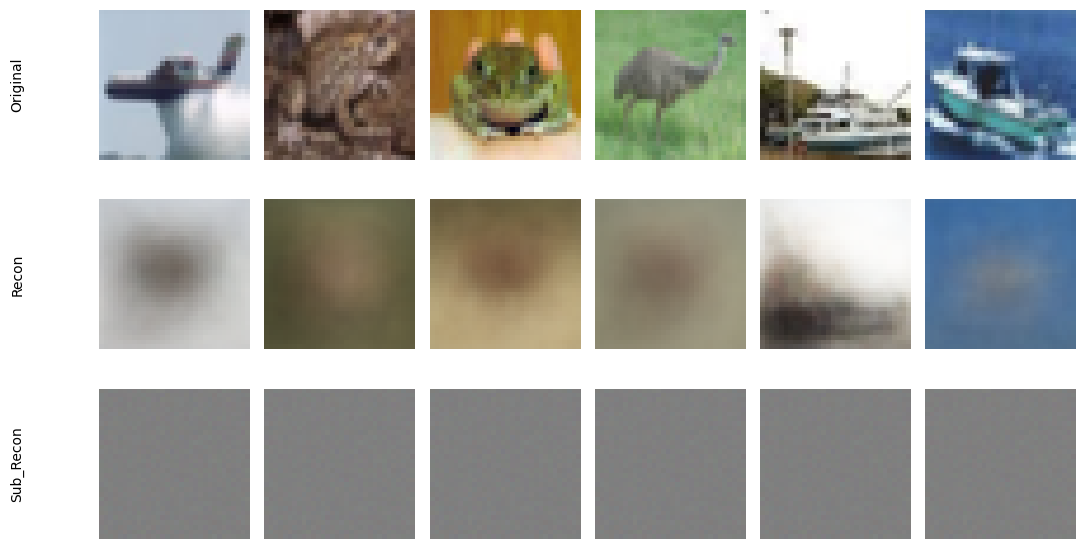

In [9]:
epoch_idx, original_imgs, recon_imgs, represent, sub_recon = outputs[-1]
n = min(6, original_imgs.size(0))  


original_imgs = original_imgs[:n].detach().cpu().view(-1, 3, 32, 32)
recon_imgs = recon_imgs[:n].detach().cpu().view(-1, 3, 32, 32)
represent = represent[:n].detach().cpu()  
sub_recon = sub_recon[:n].detach().cpu().view(-1, 3, 32, 32)


image_sets = [
    ("Original", original_imgs),
    ("Recon", recon_imgs),
    ("Sub_Recon", sub_recon),
]


# rows = len(image_sets)
# plt.figure(figsize=(1.8 * n, 2 * rows))

# for row, (title, img_batch) in enumerate(image_sets):
#     for col in range(n):
#         ax = plt.subplot(rows, n, row * n + col + 1)
#         ax.imshow(img_batch[col], cmap='gray')
#         ax.axis('off')
        

#         if col == 0:
#             ax.text(-0.5, 0.5, title, fontsize=10, va='center', ha='right', transform=ax.transAxes, rotation=90)

# plt.tight_layout()
# plt.show()

rows = len(image_sets)
plt.figure(figsize=(1.8 * n, 2 * rows))

for row, (title, img_batch) in enumerate(image_sets):
    for col in range(n):
        ax = plt.subplot(rows, n, row * n + col + 1)

        img = img_batch[col].permute(1, 2, 0).numpy()
        img = img.clip(0, 1)
        ax.imshow(img)  
        ax.axis('off')

        if col == 0:
            ax.text(-0.5, 0.5, title, fontsize=10, va='center', ha='right',
                    transform=ax.transAxes, rotation=90)

plt.tight_layout()

plt.savefig("../output/autoencoder_CIFAR10.png", dpi=300)
plt.show()


In [10]:
torch.save(model.state_dict(), "../output/v6/autoencoder_CIFAR10.pth")
torch.save(model, "../output/v6/autoencoder_CIFAR10.pth")
print("Saved")

Saved
